# AP(P)3RO PROJECT #

### Projet de deneigement intelligent de Montréal, Canada ###

#### M. Le Gras, A. Naullet, A. Calixte, P. Beaunieux ####

In [2]:
import multiprocessing as mp
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import networkx as nx

## Partie 1: Cartographie de la ville par le drone ##

<h4>Rappel Objectif:</h4> 
Calcul du parcours de toute la ville par un drone.

Ceci s'apparente donc au calcul d'un chemin Eulerien du graph correspond a Montréal

In [209]:
place = "Maisons-laffitte, France" 
G = ox.graph_from_place(place, network_type="walk")

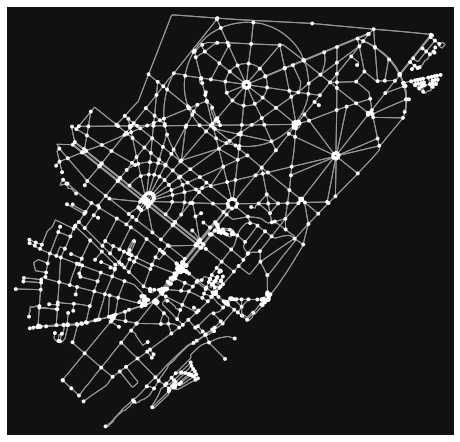

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [210]:
ox.plot_graph(G)

In [211]:
def to_graph_city(GG):
    node_list = list(GG.edges(data=True))
    graph_city = []
    for node in node_list:
        n1 = node[0]
        n2 = node[1]
        dist = node[2]["length"]
        
        
        is_oneway = node[2]["oneway"]
        if not (is_oneway):
            graph_city.append((n2,n1,dist))
            
        graph_city.append((n1,n2,dist))
    return graph_city

In [212]:
g_city = to_graph_city(G)
print("There are %d edges" % len(g_city))

There are 5940 edges


In [213]:
def to_gnx(graph_city):
    gnx = nx.Graph()
    for (a,b,c) in graph_city:
        gnx.add_edge(a,b, weight=c)
    return gnx

Gnx = to_gnx(g_city)


## Division en sous graphes

In [214]:


def edge_to_remove(graph):
    G_dict = nx.edge_betweenness_centrality(graph)
    edge = ()

    # extract the edge with highest edge betweenness centrality score
    for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
        edge = key
        break
  
    return edge

def girvan_newman(graph):
    # find number of connected components
    sg = nx.connected_components(graph)
    sg_count = nx.number_connected_components(graph)

    while(sg_count == 1):
        graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
        sg = nx.connected_components(graph)
        sg_count = nx.number_connected_components(graph)

    return sg

'''
return  all found edges from node list and Gnx edges
'''
def node_list_to_graph(node_l, Gnx_edges):
    edge_list = []
    for node1 in node_l:
        for node2 in node_l:
            if (node1,node2) in Gnx_edges:
                edge_list.append((node1,node2,Gnx_edges[(node1,node2)]["weight"]))
    return edge_list

def split_graph_in_two(Gnx, Gnx_edges):
    c = girvan_newman(Gnx.copy())
    print("[+] spliting done")
    node_groups = []
    for i in c:
        node_groups.append(list(i))
    
    graph1 = node_list_to_graph(node_groups[0],Gnx_edges) 
    graph2 = node_list_to_graph(node_groups[1],Gnx_edges)
    
    return (graph1,graph2)

In [204]:
import sys
sys.path.append("./scripts")
import importlib as iplib
import oriented_path

update = iplib.reload(oriented_path)

In [215]:

'''
Split in n sub-graphs. Utile pour separer la ville en fonction du nombre de machines disponible.
'''
def split_in_n_graph(Gnx,n):
    Gnx_edges = Gnx.edges
    count = 1
    sub_graph_list = [Gnx]
    while (count < n):
        for graph in sub_graph_list:
            (g1,g2) = split_graph_in_two(graph, Gnx_edges)
            sub_graph_list.remove(graph)
            sub_graph_list.append(to_gnx(g1))
            sub_graph_list.append(to_gnx(g2))
            count += 1
            print("[*] There are %d sub-graphs" % count)
            if (count >= n):
                break
    print("[+] Done spliting")
    return sub_graph_list




'''
retourne le chemin "couvrant" de chaque sous partie de la ville Et une liste de couleur pour osmnx
'''
def get_all_path(graph_list):
    color_list = []
    path_list  = []
    
    for gnx in graph_list:
        print(gnx)
        normal_graph = [(a,b,gnx.edges[(a,b)]["weight"]) for (a,b) in gnx.edges]
        path_list.append(oriented_path.get_best_path(normal_graph))
        
        new_color = '#%02x%02x%02x' % (tuple(np.random.choice(range(256), size=3)))
        color_list.append(new_color)
    return (color_list, path_list)

In [ ]:
(colors,paths) = get_all_path(split_in_n_graph(Gnx,2))

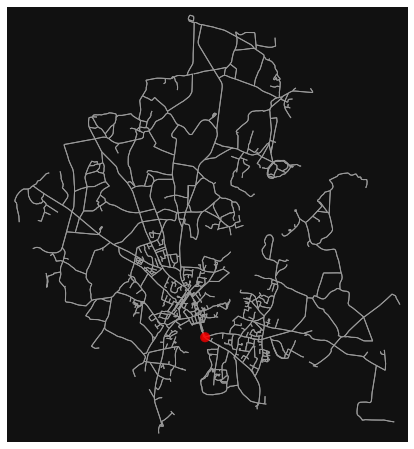

In [196]:
#fig, ax = ox.plot_graph_routes(G, paths, route_colors=colors,route_linewidth=6, node_size=0)
fig, ax = ox.plot_graph_route(G, [2154711848,2154711882],route_linewidth=6, node_size=0)